In [1]:
import time
import torch
import numpy as np
from utils import *
from h5py import File
import pennylane as qml
from typing import List
from qudit_mapping import *
from qutrit_synthesis import *
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from pennylane.pauli.conversion import _generalized_pauli_decompose

np.set_printoptions(precision=8, linewidth=1000)
torch.set_printoptions(precision=8, linewidth=1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
Sx = {2: np.array([[0, 1], [1, 0]], dtype=CDTYPE) / 2,  \
      3: np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=CDTYPE) / np.sqrt(2)}
Sy = {2: np.array([[0, -1j], [1j, 0]], dtype=CDTYPE) / 2, \
      3: np.array([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]], dtype=CDTYPE) / np.sqrt(2)}
Sz = {2: np.array([[1, 0], [0, -1]], dtype=CDTYPE) / 2, \
      3: np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=CDTYPE)}

dim = 3
print(Sx[dim])
print(Sy[dim])
print(Sz[dim])

S = Sx[dim] + Sy[dim] + Sz[dim]
SS = approx_matrix(np.kron(S, S))
print(S)
print(SS)

[[0.        +0.j 0.70710678+0.j 0.        +0.j]
 [0.70710678+0.j 0.        +0.j 0.70710678+0.j]
 [0.        +0.j 0.70710678+0.j 0.        +0.j]]
[[ 0.+0.j         -0.-0.70710678j  0.+0.j        ]
 [ 0.+0.70710678j  0.+0.j         -0.-0.70710678j]
 [ 0.+0.j          0.+0.70710678j  0.+0.j        ]]
[[ 1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j]]
[[ 1.        +0.j          0.70710678-0.70710678j  0.        +0.j        ]
 [ 0.70710678+0.70710678j  0.        +0.j          0.70710678-0.70710678j]
 [ 0.        +0.j          0.70710678+0.70710678j -1.        +0.j        ]]
[[ 1.        +0.j          0.70710678-0.70710678j  0.        +0.j          0.70710678-0.70710678j  0.        -1.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.70710678+0.70710678j  0.        +0.j          0.70710678-0.70710678j  1.        +0.j          0.        +0.j          0.        -1.j          0.        +0.j          0. 

In [9]:
SxE = symmetric_encoding(Sx[dim])
SyE = symmetric_encoding(Sy[dim])
SzE = symmetric_encoding(Sz[dim])
print(*_generalized_pauli_decompose(SxE))
print(SxE)
print(*_generalized_pauli_decompose(SyE))
print(SyE)
print(*_generalized_pauli_decompose(SzE))
print(SzE)

[0.5+0.j 0.5+0.j] [I(0) @ X(1), X(0) @ I(1)]
[[0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0.5+0.j 0.5+0.j 0. +0.j]]
[0.5+0.j 0.5+0.j] [I(0) @ Y(1), Y(0) @ I(1)]
[[0.+0.j  0.-0.5j 0.-0.5j 0.+0.j ]
 [0.+0.5j 0.+0.j  0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j  0.+0.j  0.-0.5j]
 [0.+0.j  0.+0.5j 0.+0.5j 0.+0.j ]]
[0.5+0.j 0.5+0.j] [I(0) @ Z(1), Z(0) @ I(1)]
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


In [ ]:
import time
import torch
import numpy as np
from h5py import File
import pennylane as qml
from qudit_mapping import symmetric_encoding
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=8, linewidth=1000)
torch.set_printoptions(precision=8, linewidth=1000)

path = '../QuditVQE/data_232/from_classical_to_violation_dense'
s = File(f'{path}/232_d3_D9_model1216_RDM2_iter1_target_state_vector.mat')
state = s['target_state_vec'][:].view('complex')
nqd = s['N'][0]
s.close()

dim = 3
nqb = nqd * (dim - 1)
dev = qml.device('default.qubit', nqb)
print(f'Number of qudits: {nqd}')
print(f'Number of qubits: {nqb}')

if torch.cuda.is_available() and nqb >= 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'PyTorch Device: {device}')

psi_sym = symmetric_encoding(state, nqd)
psi_sym = torch.from_numpy(psi_sym)

pr_num = (nqd - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
params = torch.tensor(init_params, device=device, requires_grad=True)
optimizer = torch.optim.Adam([params], lr=0.1)


@qml.qnode(dev, interface='torch')
def qutrit_symmetric_ansatz(params: torch.Tensor):
    params = params.reshape(nqd - 1, NUM_PR)
    for i in range(nqd - 1):
        obj = list(range(nqb - (dim - 1) * (i + 2), nqb - (dim - 1) * i))
        two_qutrit_unitary_synthesis(dim, params[i], obj)
    return qml.state()


def cost_fn(params: torch.Tensor):
    psi_circ = qutrit_symmetric_ansatz(params)
    fidelity = torch.abs(psi_circ.conj() @ psi_sym)**2
    return fidelity


epochs = 500
start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = cost_fn(params)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'{count:3d}/{epochs}, Loss: {loss.item():.15f}, Fidelity: {1-loss.item():.15f}, {t:.2f}')

In [3]:
def qutrit_symmetric_ansatz(params):
    params = params.reshape(nqd - 1, NUM_PR)
    for i in range(nqd - 1):
        obj = list(range(nqb - (dim - 1) * (i + 2), nqb - (dim - 1) * i))
        two_qutrit_unitary_synthesis(dim, params[i], obj)


dim, nqd = 3, 3
nqb = nqd * (dim - 1)
np.random.seed(42)
params = np.random.rand((nqd - 1) * NUM_PR)
matrix = qml.matrix(qutrit_symmetric_ansatz, range(nqb))(params)
print(approx_matrix(matrix))
# mat = loadmat('../QuditVQE/test.mat')['a']
# np.allclose(matrix, mat)

[[ 6.21607720e-01-0.04737528j  4.67081166e-02-0.2106583j   4.67081166e-02-0.2106583j  ... -5.41934514e-03+0.00315051j -5.41934514e-03+0.00315051j  8.43030062e-03+0.00610703j]
 [ 2.99489556e-01+0.04337585j -4.18124867e-01+0.46586636j  1.61678061e-01-0.02987782j ...  1.17897670e-02+0.02331467j -3.88223724e-05-0.00101186j -5.66863380e-03-0.00552595j]
 [ 2.99489556e-01+0.04337585j  1.61678061e-01-0.02987782j -4.18124867e-01+0.46586636j ... -3.88223724e-05-0.00101186j  1.17897670e-02+0.02331467j -5.66863380e-03-0.00552595j]
 ...
 [ 2.67923860e-02-0.0145774j  -5.22909496e-03+0.06385109j  1.18337568e-02-0.01143947j ...  3.80442060e-01-0.26538137j -1.20512526e-01-0.04717394j -7.61742536e-02+0.1447474j ]
 [ 2.67923860e-02-0.0145774j   1.18337568e-02-0.01143947j -5.22909496e-03+0.06385109j ... -1.20512526e-01-0.04717394j  3.80442060e-01-0.26538137j -7.61742536e-02+0.1447474j ]
 [ 3.47629105e-03-0.00569392j -1.10290055e-02-0.03284591j -1.10290055e-02-0.03284591j ... -8.94530253e-02+0.08061401j -8

[[ 3.24275120e-02-8.24144988e-01j -2.58654032e-01-9.40788551e-02j -2.58654032e-01-9.40788551e-02j  3.06461032e-01+2.69569171e-01j -1.02452717e-02+4.46128781e-04j  1.94408372e-03-1.70532475e-03j  1.94408372e-03-1.70532475e-03j -5.13116921e-03-2.31688308e-02j -1.02452717e-02+4.46128781e-04j  1.94408372e-03-1.70532475e-03j  1.94408372e-03-1.70532475e-03j -5.13116921e-03-2.31688308e-02j  9.38636678e-04+3.96675800e-03j -8.23549780e-04+3.40310960e-03j -8.23549780e-04+3.40310960e-03j  1.12092016e-02+1.05832570e-02j]
 [ 1.03308167e-01-3.80588446e-01j  5.43822533e-01+6.13588574e-01j -7.46726644e-03-2.20725250e-01j -2.26398482e-01-2.66659230e-01j  3.03486147e-03+7.12692221e-03j  9.03805521e-04-1.10883138e-02j  9.03805521e-04-1.10883138e-02j -1.13520011e-02+4.40939049e-03j  3.03486147e-03+7.12692221e-03j  9.03805521e-04-1.10883138e-02j  9.03805521e-04-1.10883138e-02j -1.13520011e-02+4.40939049e-03j  3.60602416e-03-2.15404234e-03j  5.53033270e-03+6.39605471e-03j  5.53033270e-03+6.39605471e-03j  2.

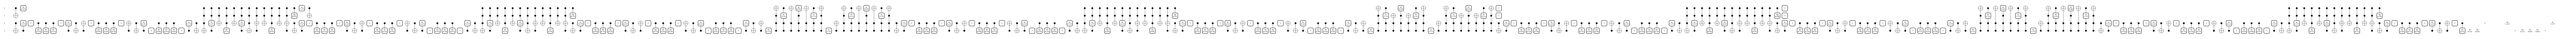

In [4]:
def qutrit_symmetric_ansatz(pr, obj: List[int]):
    dim = 3
    if len(obj) == 2:
        single_qutrit_unitary_synthesis(dim, pr, obj)
    elif len(obj) == 4:
        two_qutrit_unitary_synthesis(dim, pr, obj)
    else:
        raise ValueError('Currently only applicable when the n_qutrits is 1 or 2, which means the n_qubits must be 2 or 4')


nq = 4
obj = [0, 1, 2, 3]
np.random.seed(42)
params = np.random.rand(NUM_PR)
qml.draw_mpl(qutrit_symmetric_ansatz, decimals=2)(params, obj)
matrix = qml.matrix(qutrit_symmetric_ansatz, obj)(params, obj)
print(approx_matrix(matrix))
# mat = loadmat('../QuditVQE/test.mat')['a']
# np.allclose(matrix, mat)

[[ 1.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.8782411 -0.23360524j -0.1217589 -0.23360524j -0.31845681+0.05753068j]
 [ 0.        +0.j         -0.1217589 -0.23360524j  0.8782411 -0.23360524j -0.31845681+0.05753068j]
 [ 0.        +0.j          0.31845681+0.05753068j  0.31845681+0.05753068j  0.7564822 +0.46721048j]]
[[ 0.52951333-0.71089062j -0.27402203+0.17029516j -0.27402203+0.17029516j -0.07602919-0.01710797j]
 [ 0.28009684-0.02635216j  0.89932707+0.08484707j -0.10067293+0.08484707j -0.29419846-0.03124607j]
 [ 0.28009684-0.02635216j -0.10067293+0.08484707j  0.89932707+0.08484707j -0.29419846-0.03124607j]
 [ 0.22969373+0.05651187j  0.15624818+0.19538607j  0.15624818+0.19538607j  0.68806211+0.58774085j]]


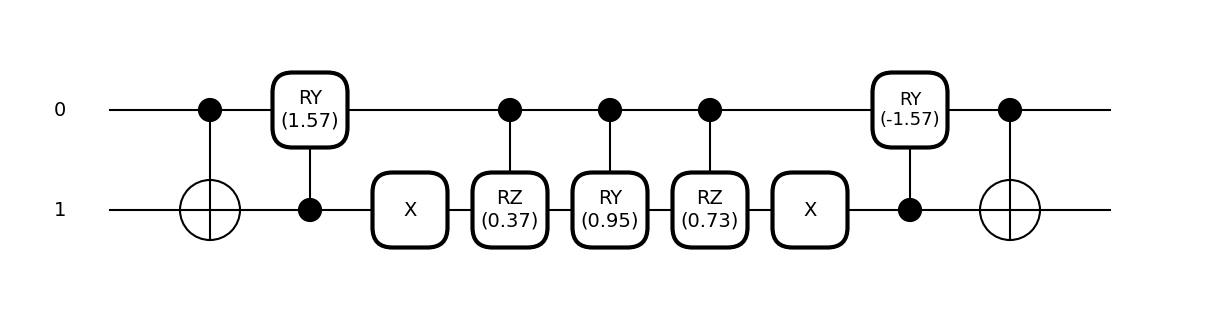

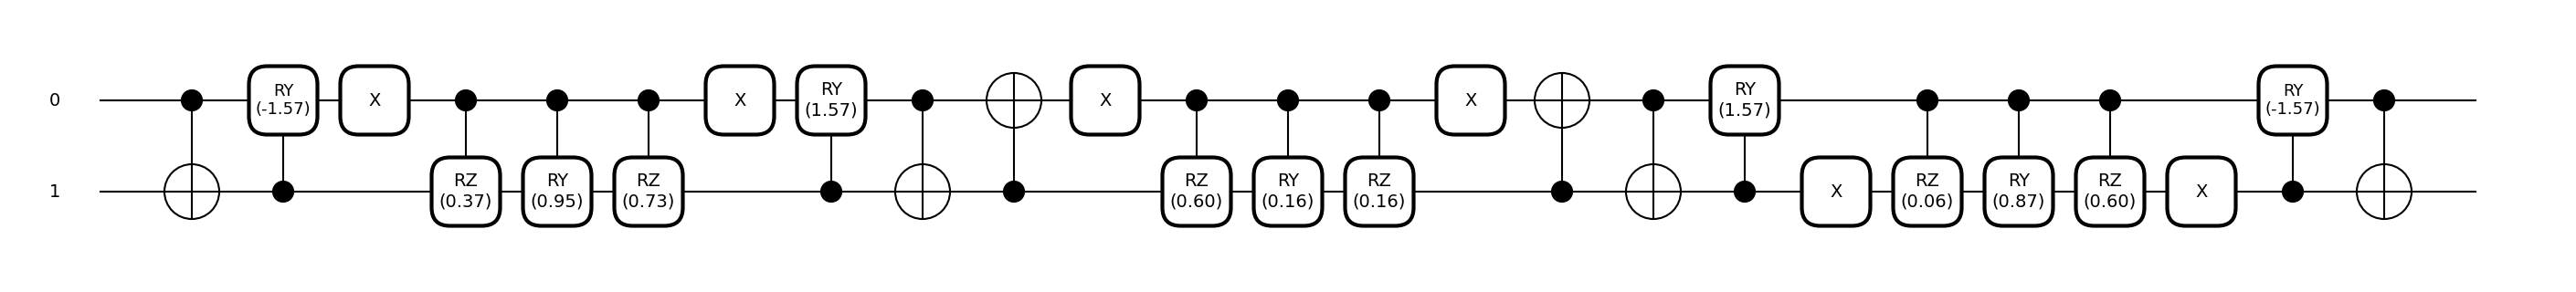

In [5]:
def two_level_unitary_synthesis(dim: int, pr, ind: List[int], obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 3:
        raise ValueError(f'The number of params {len(pr)} should be 3')
    if len(ind) != 2:
        raise ValueError(f'The qutrit unitary index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'The qutrit unitary index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= dim:
        raise ValueError(f'The qutrit unitary index {ind} should in 0 to {dim-1}')
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    circ_ind(ind, obj)
    circ_zyz(pr, obj)
    qml.adjoint(circ_ind, lazy=False)(ind, obj)


def single_qutrit_unitary_synthesis(dim: int, pr, obj: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    if len(pr) != 9:
        raise ValueError(f'The number of params {len(pr)} should be 9')
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    index = [[0, 1], [0, 2], [1, 2]]
    pr = pr.reshape(3, 3)
    for i, ind in enumerate(index):
        two_level_unitary_synthesis(dim, pr[i], ind, obj)


nq = 2
dim = 3
ind = [1, 2]
obj = [0, 1]
np.random.seed(42)
params = np.random.rand(3)
qml.draw_mpl(two_level_unitary_synthesis, decimals=2)(dim, params, ind, obj)
matrix = qml.matrix(two_level_unitary_synthesis, obj)(dim, params, ind, obj)
print(approx_matrix(matrix))

np.random.seed(42)
params = np.random.rand(9)
qml.draw_mpl(single_qutrit_unitary_synthesis, decimals=2)(dim, params, obj)
matrix = qml.matrix(single_qutrit_unitary_synthesis, obj)(dim, params, obj)
print(approx_matrix(matrix))

[[ 0.98251615 -0.13164729 -0.13164729  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.13164729  0.99125807 -0.00874193  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.13164729 -0.00874193  0.99125807  0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.        

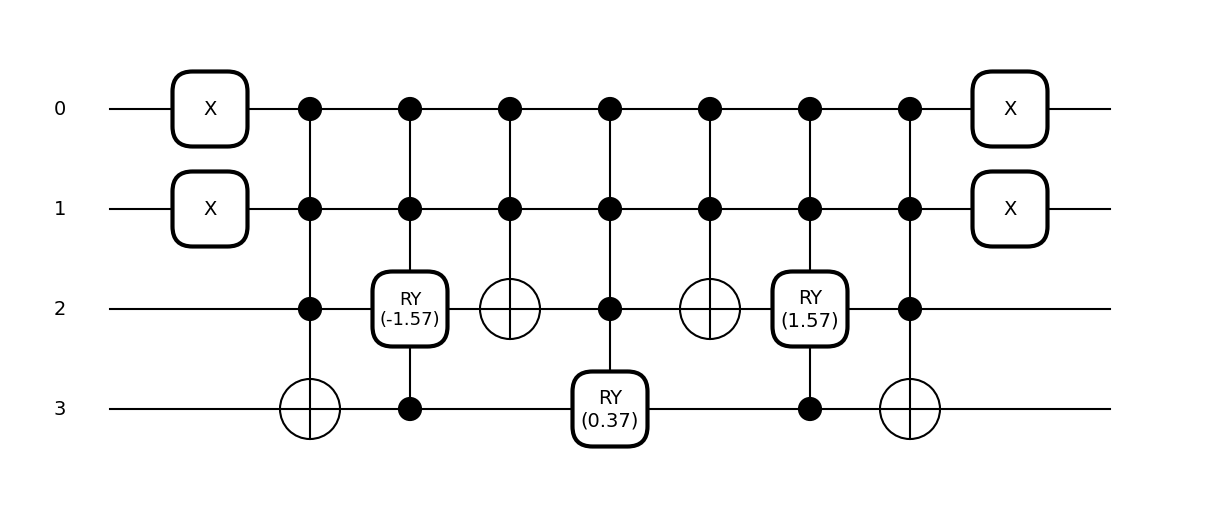

In [6]:
def controlled_rotation_synthesis(dim: int, pr, state: int, obj: int, ctrl: List[int], ind: List[int], name: str):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    ctrl_state = list(range(dim))
    if state not in ctrl_state:
        raise ValueError(f'The control state is not in {ctrl_state}')
    if len(pr) != 1:
        raise ValueError(f'The number of params {len(pr)} should be 1')
    if len(ind) != 2:
        raise ValueError(f'The qutrit unitary index length {len(ind)} should be 2')
    if len(set(ind)) != len(ind):
        raise ValueError(f'The qutrit unitary index {ind} cannot be repeated')
    if min(ind) < 0 or max(ind) >= dim:
        raise ValueError(f'The qutrit unitary index {ind} should in 0 to {dim-1}')
    circ_ctrl_state(state, ctrl)
    circ_ctrl_ind(ind, obj, ctrl)
    circ_ctrl_gate(name, pr[0], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)(ind, obj, ctrl)
    qml.adjoint(circ_ctrl_state, lazy=False)(state, ctrl)


nq = 4
dim = 3
state = 0
ind = [0, 1]
name = 'RY'
obj, ctrl = 3, [2, 1, 0]
np.random.seed(42)
params = np.random.rand(1)
qml.draw_mpl(controlled_rotation_synthesis, decimals=2)(dim, params, state, obj, ctrl, ind, name)
matrix = qml.matrix(controlled_rotation_synthesis, range(nq))(dim, params, state, obj, ctrl, ind, name)
print(approx_matrix(matrix))

[[ 0.99759509+0.06931111j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.67512439+0.73175483j -0.06871883+0.06340069j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.06871883+0.06340069j  0.67512439+0.73175483j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.     

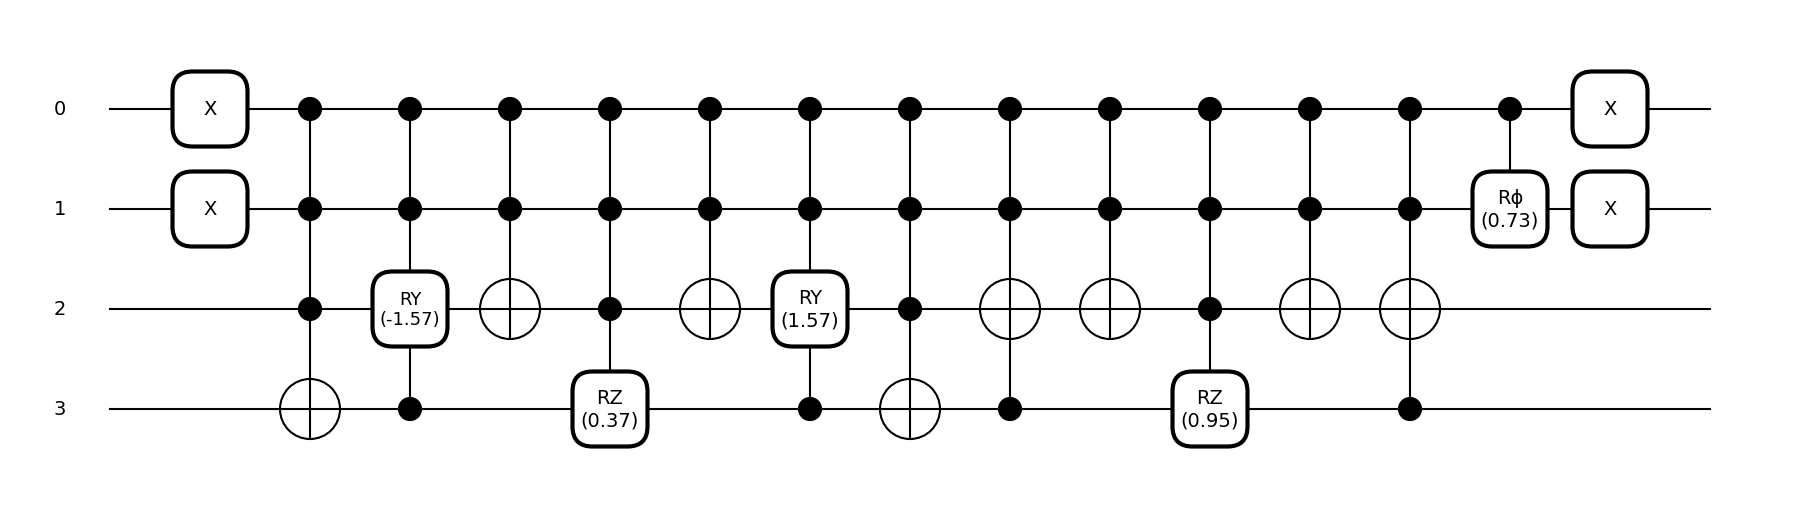

In [7]:
def controlled_diagonal_synthesis(dim: int, pr, state: int, obj: int, ctrl: List[int]):
    if dim != 3:
        raise ValueError('Only works when dim = 3')
    ctrl_state = list(range(dim))
    if state not in ctrl_state:
        raise ValueError(f'The control state is not in {ctrl_state}')
    if len(pr) != 3:
        raise ValueError(f'The number of params {len(pr)} should be 3')
    circ_ctrl_state(state, ctrl)
    circ_ctrl_ind([0, 1], obj, ctrl)
    circ_ctrl_gate('RZ', pr[0], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)([0, 1], obj, ctrl)
    circ_ctrl_ind([0, 2], obj, ctrl)
    circ_ctrl_gate('RZ', pr[1], obj, ctrl)
    qml.adjoint(circ_ctrl_ind, lazy=False)([0, 2], obj, ctrl)
    circ_ctrl_gate('PS', pr[2], ctrl[1], ctrl[2])
    qml.adjoint(circ_ctrl_state, lazy=False)(state, ctrl)


nq = 4
dim = 3
state = 0
obj, ctrl = 3, [2, 1, 0]
np.random.seed(42)
params = np.random.rand(3)
qml.draw_mpl(controlled_diagonal_synthesis, decimals=2)(dim, params, state, obj, ctrl)
matrix = qml.matrix(controlled_diagonal_synthesis, range(nq))(dim, params, state, obj, ctrl)
print(approx_matrix(matrix))